# Plot First, Model Second: Exploring Transformers and the Power of Data Visualization

In this notebook, we'll explore one of the most intuitive -- and universally applicable -- business use cases for machine learning: predicting customer churn. After all, who wants to *lose* a customer?

For this deep dive, we'll take a look at a popular data science/ML dataset -- the **"Telco-Customer-Churn.csv" dataset**, which was originally created by IBM. The tech giant designed this synthetic dataset to simulate customer behavior at a ficticious telecom company for use with Watson Analytics and other AI tools. You can read all about it [right here on GitHub](https://github.com/IBM/telco-customer-churn-on-icp4d).

Along the way, we'll learn all about data preprocessing, and powerful and elegant transformers like `SimpleImputer`, `OneHotEncoder`, `make_pipeline`, and `make_column_transformer`.

At the close of the pipeline-building process, we end up at a final insight -- it's just not the one we were expecting.

Here's the path we'll be following:

**The Road Map**:
- Import pandas and load the dataset for initial exploration
- Begin preprocessing, check the data types
- Visualize `Churn` -- the target variable
- Set X and y, and split the training and test sets
- Import the transformers and build the pipeline
- Evaluate model performance with 5-fold cross-validation
- Build a scaled pipeline
- Evaluate the performance of the scaled models
- Plot first, model second: The scaled takeaway

## Acknowledgements

This notebook was inspired by an assignment designed by Tao Li,  Associate Professor in the Department of Information & Analytics at Santa Clara University's Leavey School of Business. As always, thanks to the Professor for creating assignments that inspire further investigation.

## Import pandas and load and explore the dataset

In [2]:
# Import pandas as pd
import pandas as pd

# Load the datset
data = pd.read_csv("Telco-Customer-Churn.csv")

# Display the first five rows of the DataFrame
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Time to **start exploring**.

In [4]:
# Check the shape of the DataFrame
data.shape

(7043, 21)

Immediately, we see that we're working with **over 7,000 customers** and 21 columns -- including `Churn` our target variable. Next, let's take a see as to what might be missing.

In [5]:
# Check for any missing values
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

The above output not only tells us that there are **0 missing values** in the dataset, but also gives a lay of the land regarding **continuous and categorical features**. While we'd already scoped out `Churn` as the target, we can also now see that we have three continuous features: `tenure`, `MonthlyCharges` and `TotalCharges`, and the rest are all categorical. 

## Begin preprocessing, check the data types

Before we can import `scikit-learn` and build a model, we'll need to preprocess both the continuous *and* categorical features. Will start with those three continuous ones. Let's begin by taking a look a the data types.

In [6]:
# Let's check out the data types of those columns
print(data['tenure'].dtype)
print(data['MonthlyCharges'].dtype)
print(data['TotalCharges'].dtype)

int64
float64
object


This is an important catch. One of our continuous variables, `TotalCharges`, looks like a number, but it's *actually* a string. And there actually *are* missing values, which eluded our intial check with `.isna()`. Let's clean that up.

In [7]:
# Import numpy
import numpy as np

# Remove any leading/trailing spaces and replace blank entries with NaN
data['TotalCharges'] = data['TotalCharges'].str.strip().replace('', np.nan)

# Turn the the cleaned column into numeric data (float)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

# Drop rows where TotalCharges is missing -- NaN
data = data.dropna(subset=['TotalCharges'])

Now, check the data type once again.

In [8]:
# Now let's check the data type of 'TotalCharges' once more
print(data['TotalCharges'].dtype)

float64


## Visualize `Churn` -- the target variable

Next, we'll take a quick look at our target variable, `Churn`, whether a customer drops Telco or not. First, we'll take a peek at the distribution.

In [10]:
# Display the 'Churn' value counts
churn_counts = data['Churn'].value_counts()
churn_counts

Churn
No     5163
Yes    1869
Name: count, dtype: int64

And now, we'll visualize that split with a simple plot in `matplotlib`.

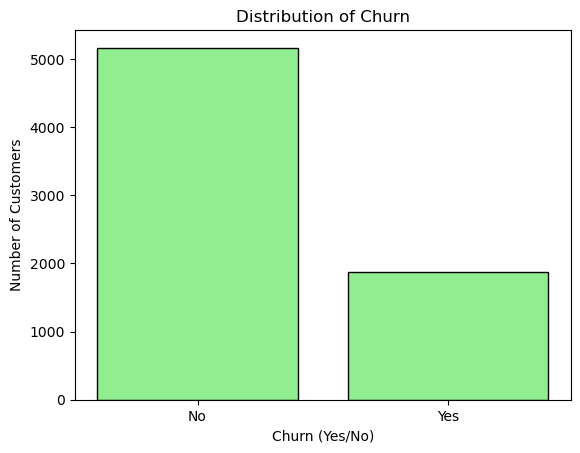

In [13]:
# Import matplotlb
import matplotlib.pyplot as plt

# Plot the target variable -- 'Churn' -- as a bar plot
plt.bar(churn_counts.index, churn_counts.values, color='lightgreen', edgecolor='black')
plt.title('Distribution of Churn')
plt.xlabel('Churn (Yes/No)')
plt.ylabel('Number of Customers')
plt.show()

We're now ready to dig into the model-building process.

## Set X and y, and split the training and test sets

To begin, **let's set X and y**.

In [15]:
# Set X and y as specified
# Important note: Make sure to drop y
X = data.drop(columns='Churn')

# Check the shape
X.shape

(7032, 20)

In [16]:
# Now set y
y = data['Churn']

# Check the shape
y.shape

(7032,)

Now, to **make a 90/10 split of the training and test sets**. We'll also be sure to set `random_state=0` for reproducibility. 

In [17]:
# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Split the training and test sets; Set random_state=0 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

It's always good practice to check the shapes of the four new sets.

In [18]:
# Check the shape of X_train
X_train.shape

(6328, 20)

In [19]:
# Check the shape of X_test
X_test.shape

(704, 20)

In [20]:
# Check the shape of y_train
y_train.shape

(6328,)

In [21]:
# And check the shape of y_test
y_test.shape

(704,)

## Import the transformers and build the pipeline

Time to **build the pipeline**. we'll be evaluating three models: 
1. `LinearRegression`
2. `LinearSVC`
3. `KNeighborsClassifier`

We'll evaluate the performance of these three models using 5-fold cross validationa and their default parameters. To begin, we need to get back to those continuous and categorical variables and make sure they're ready for `scikit-learn`. First, let's put the respective features into super columns.

In [22]:
# Create two super columns for the categorical and numeric columns, respectively
col_cat = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
           'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
           'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
           'Contract', 'PaperlessBilling', 'PaymentMethod']

col_num = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create subsets of the categorical and numerical columns for both the training and test sets
X_train_cat = X_train[col_cat]
X_train_num = X_train[col_num]
X_test_cat = X_test[col_cat]
X_test_num = X_test[col_num]

Next, we'll **import the transformers** and models from `scikit-learn`. Let's take a look at `SimpleImputer` and `OneHotEncoder`, in particular, both of which are essential for preprocessing data for ML tasks. 

For continuous features, `SimpleImputer` cleans up variables with missing values. Meanwhile, `OneHotEncoder`turns categorical variables into *numerical* format so that the model can make sense of them.

In [24]:
# Import transformers and models from sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

To **build the pipelines**, we'll make use of `make_pipeline` and `make_column_transformer`, a couple of beautiful little pieces of code from `scikit-learn` that help us chain together preprocessing steps in a clean, reusable workflow:

- `make_pipeline` allows us to stack transformers (like `SimpleImputer` and `OneHotEncoder`) so that each step flows into the next automatically.
- `make_column_transformer` lets us apply different pipelines to different column types — for instance, one pipeline for categorical features and another for continuous ones -- all in a single preprocessor.

In [28]:
# Build the pipeline for categorical features:
# First, impute missing values with a constant placeholder, then apply one-hot encoding
pipe_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))

# Now build the numerical pipeline
# Note: We are imputing the missing values using the default strategy, or mean
pipe_num = make_pipeline(SimpleImputer())

# Use make_column_transfomer to combine the two pipelines
# Apply the categorical pipeline to categorical columns and the numerical pipeline to numerical columns
preprocessor = make_column_transformer((pipe_cat, col_cat), (pipe_num, col_num))

And now we'll apply the **combined pipelines** to each of the three models.

In [27]:
# Build the pipelines for each model
pipe_logreg = make_pipeline(preprocessor, LogisticRegression())
pipe_svc = make_pipeline(preprocessor, LinearSVC())
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())

Let's **visualize what we just built** to see all the proccesses we've chained together.

In [29]:
# Check 'pipe_logreg`
pipe_logreg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('logisticregression', LogisticRegression())])

## Evaluate model performance with 5-fold cross validation

Next, we'll **evaluate the three models** using 5-fold cross-validation with their default parameters.

First up, `LogisticRegression`.

In [31]:
# Import cross_validate
from sklearn.model_selection import cross_validate

# Run Cross-validation for Logistic Regression
scores_logreg = cross_validate(pipe_logreg, X, y, cv=5, return_train_score=True)
scores_logreg_df = pd.DataFrame(scores_logreg)
print("Logistic Regression (No Scaling) CV Results:")
print(scores_logreg_df[['train_score', 'test_score']].mean())

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Logistic Regression (No Scaling) CV Results:
train_score    0.806670
test_score     0.803896
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Next, `LinearSVC`.

In [32]:
# Run Cross-validation for LinearSVC
scores_svc = cross_validate(pipe_svc, X, y, cv=5, return_train_score=True)
scores_svc_df = pd.DataFrame(scores_svc)
print("Linear SVC (No Scaling) CV Results:")
print(scores_svc_df[['train_score', 'test_score']].mean())

Linear SVC (No Scaling) CV Results:
train_score    0.804252
test_score     0.802473
dtype: float64


And now, `KNeighborsClassifier`.

In [35]:
# Run Cross-validation for kNN
scores_knn = cross_validate(pipe_knn, X, y, cv=5, return_train_score=True)
scores_knn_df = pd.DataFrame(scores_knn)
print("kNN (No Scaling) CV Results:")
print(scores_knn_df[['train_score', 'test_score']].mean())

kNN (No Scaling) CV Results:
train_score    0.831414
test_score     0.760949
dtype: float64


### Intial analysis of the models:


The results are mostly similar, especially for the `LogisticRegression` and `LinearSVC` models. The `KNeighborsClassifier` shows the largest gap between the training and test sets, indicating potential overfitting.

As you likely noticed in the warning above, the `LogisticRegression` never fully convereged, a hint that perhaps the features need to be scaled. Next up, will add `StandardScaler` to our pipeline building process and see how scaling the continuous features impacts model performance.

## Build a scaled pipeline

Now, we'll add `StandardScaler` to the pipeline building process to make sure all the continuous or numeric features are **on the same scale**. This helps the model learn better and faster.

In [36]:
# Now build the numerical pipeline -- WITH StandardScaler() this time
pipe_num_scaled = make_pipeline(SimpleImputer(), StandardScaler())

Antoher quick visualization, so to speak.

In [37]:
# Check the results
pipe_num_scaled

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

With the features scaled, it's now time to combine this pipeline with the one we already built for the categorical features. Once again, we'll be utilizing `make_column_transformer`.

In [39]:
# Let's add this to the categorical pipe we already built
# Use make_column_transfomer to combine the two pipes
preprocessor_scaled = make_column_transformer((pipe_cat, col_cat), (pipe_num_scaled, col_num))

In [40]:
# Check the results
preprocessor_scaled

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges'])])

Now, **apply the new, scaled pipeline** to the models.

In [42]:
# Build the pipelines for each model
pipe_logreg_scaled = make_pipeline(preprocessor_scaled, LogisticRegression())
pipe_svc_scaled = make_pipeline(preprocessor_scaled, LinearSVC())
pipe_knn_scaled = make_pipeline(preprocessor_scaled, KNeighborsClassifier())

Here's a great way to visualize how it all comes together.

In [43]:
# As an example, take a look at 'pipe_logreg_scaled'
pipe_logreg_scaled 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('logisticregression', LogisticRegression())])

## Evaluate the performance of the scaled models

We'll run cross-validation again, to once again **evaluate the performance**.

As before, we begin with `LogisticRegression`.

In [45]:
# Run Cross-validation for Logistic Regression
scores_logreg_scaled = cross_validate(pipe_logreg_scaled, X, y, cv=5, return_train_score=True)
scores_logreg_scaled_df = pd.DataFrame(scores_logreg_scaled)
print("Logistic Regression With Scaling) CV Results:")
print(scores_logreg_scaled_df[['train_score', 'test_score']].mean())

Logistic Regression With Scaling) CV Results:
train_score    0.806136
test_score     0.803896
dtype: float64


Next up, `LinearSVC`.

In [32]:
# Run Cross-validation for LinearSVC
scores_svc_scaled = cross_validate(pipe_svc_scaled, X, y, cv=5, return_train_score=True)
scores_svc_scaled_df = pd.DataFrame(scores_svc_scaled)
print("Linear SVC With Scaling) CV Results:")
print(scores_svc_scaled_df[['train_score', 'test_score']].mean())

Linear SVC With Scaling) CV Results:
train_score    0.804572
test_score     0.801904
dtype: float64


And, last, `KNeighborsClassifier`.

In [48]:
# Run Cross-validation for LinearSVC
scores_knn_scaled = cross_validate(pipe_knn_scaled, X, y, cv=5, return_train_score=True)
scores_knn_scaled_df = pd.DataFrame(scores_knn_scaled)
print("kNN With Scaling CV Results:")
print(scores_knn_scaled_df[['train_score', 'test_score']].mean())

kNN With Scaling CV Results:
train_score    0.838631
test_score     0.771614
dtype: float64


### Analyzing the impact of scaling:

Scaling the continuous features using `StandardScaler` was *supposedly* to be the game-changer, and yet, there was no grand reveal. Even after scaling our continuous features, the performance of the three models did not significantly change. That is possible for a couple of reasons:

1. Only three features were continuous.
2. The majority of the predictive signal may have come from the categorical features, which were one-hot encoded and unaffected by scaling.

But there is **one more important angle to consider**.

## Plot first, model second: The scaled takeaway

Way back at the top of this notebook, we undertook some preliminary EDA, or exploratory data analysis, and even plotted the target variable `Churn`. What we failed to plot were the three continuous variables: `tenure`, `MonthlyCharges` and `TotalCharges`. Let's do so now. 

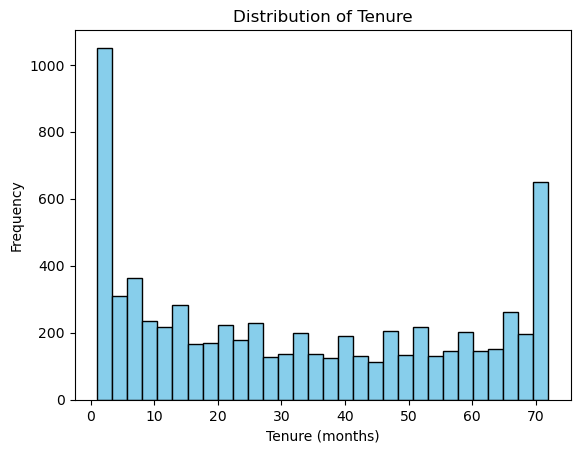

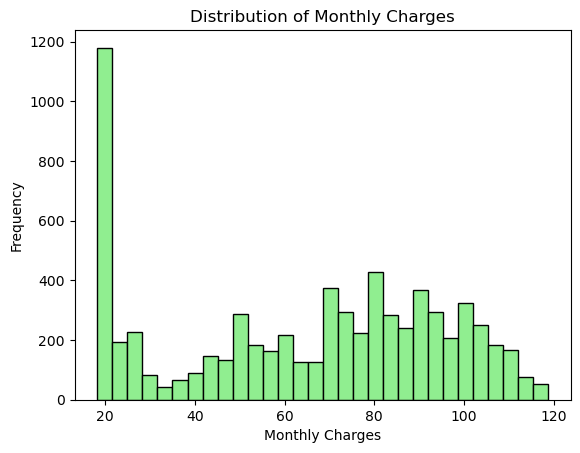

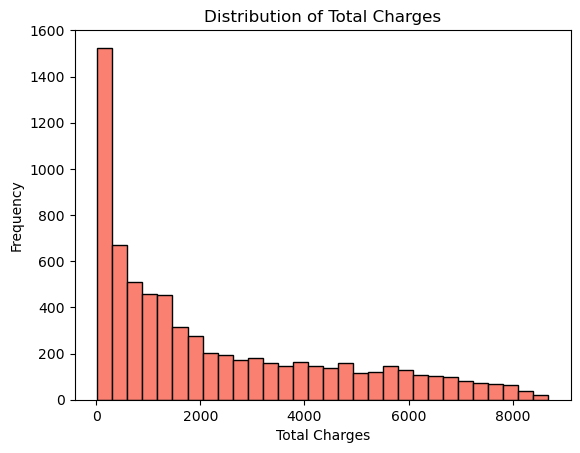

In [49]:
# Plot the tenure distribution
plt.hist(data['tenure'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Frequency')
plt.show()

# Plot monthly charges
plt.hist(data['MonthlyCharges'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.show()

# Plot total charges
plt.hist(data['TotalCharges'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

And there it is -- our **scaled takeaway**. Our plots indicate that of the three continuous variables, only `TotalCharges` was meaningfully out of scale and likely to be impacted by the addition of `StandardScaler` to the model-building process. This helps explain why scaling didn't work, or more precisely, didn't improve model performance. This moment speaks to the power of data visualization. And the importance of always thinking intuitively -- it makes perfect sense that `TotalCharges` would be out of scale as it's literally `MonthlyCharges` x `tenure`. It's like a built-in engineered feature. A good reminder to never lose the forest for the trees, even when working on a task as complex as machine learning. 